# Расчет затрат энергии в распределенной модели по Спенсеру (2012)

 - используем `NEURON`, но всю модель делаем из `Python` (кроме `NMODL`-файлов)

In [1]:
from itertools import chain

In [2]:
%pylab inline
#%pylab tk

style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [3]:
R = 8314.4  # Universal gaz constant, mJ / mole*K
F = 96485   # Faraday constant [C/mol]
F_ATP = 50 # kJ/mol

avogadro = 6.022e23 # N_a

In [4]:
from neuron import h, gui

In [5]:
# number of segments per dendrite should be large to allow for precise synapse location
Ndend = 4


h.celsius = 33.0
    

all_currents = ['leak', 'nasab', 'kltab', 'khtab', 'ihsab']

soma = h.Section(name='soma')
ax_stub = h.Section(name='ax_stub')
ax_init = h.Section(name='ax_init')
dendrites = [h.Section(name='dend-%d'%i) for i in range(Ndend)]

def init_octopus(Ldend=250, Ndendseg=201, Eleak = -62.0):
    # Soma
    soma.L,soma.diam = 25, 25
    soma.nseg = 1
    
    # Axon
    ax_stub.diam = ax_init.diam = 3.0
    ax_stub.L = 30
    ax_init.L = 10
    ax_init.connect(ax_stub, 1, 0)
    ax_stub.connect(soma, 0, 0)
    
    # Dendrites
    for d in dendrites:
        d.diam = 3
        d.L = Ldend
        d.nseg = Ndendseg
        d.connect(soma, 1, 0)
        
    for sec in h.allsec():
        sec.Ra = 100  # Spencer
        sec.cm = 0.9      # Spencer
        for cur in all_currents:
            sec.insert(cur)
        for seg in sec:
            seg.leak.erev = Eleak
            seg.leak.g = 0.002  # Spencer
            #seg.hcno.eh = -38
            seg.ihsab.eh = -38 # Spencer
            
            seg.nasab.gbar = 0
            seg.ihsab.gbar = 0
            seg.kltab.gbar = 0
            seg.khtab.gbar = 0
            #seg.hcno.gbar = 0
            
        sec.ena = 55.0
        sec.ek = -70.0
    
    # ... there must be a more compact way...
    for seg in ax_init:
        seg.nasab.gbar = 4.244

        
    for seg in soma:
        seg.kltab.gbar = 0.0407
        seg.khtab.gbar = 0.0061
        seg.ihsab.gbar = 0.0076
    
    for seg in chain(*dendrites):
        seg.kltab.gbar = 2.7e-3 # Table 3 Spencer 2012
        seg.khtab.gbar = 0.6e-3 # Table 3 Spencer 2012


        
    
    
    
    
init_octopus()

## Energy calc

In [6]:
def split_mixed(v, gm, erev,ek=-70,ena=55):
    gratio = float((ena-erev))/(erev-ek)
    denom = (v*(gratio+1) - gratio*ek - ena)
    if (abs(v-erev) < 1):
        gnah = gm/(gratio + 1)
    else: 
        gnah = gm*(v-erev)/denom
    inah = gnah*(v-ena)
    ikh = gratio*gnah*(v-ek)
    return inah, ikh


def ratp_atwell(V, Rin, Ena = 50, Ek = -70):
    "returns resting ATP consumption rate in pmol ATP/s"
    # I take Rm in MOhms and V in mV
    # Thus, result is in nmole/sec
    out = (Ena-V)*(V-Ek)/(F*Rin*(V + 2*Ena - 3*Ek))
    return out*1e3 # nmol -> pmol

def pmol2molecules(x):
    return x*1e-12*avogadro

def atp2J(nATP):
    "Convert pmol ATP/s to energy usage in pJoule/s"
    return F_ATP * nATP * 1e3
    pas

def J2atp(nJ):
    "convert from Joule/s to mol ATP/s"
    return (nJ/F_ATP)*1e-3



def mouj_Erate2(seg, erev_ih = -38):
    v = seg.v
    acc = 0.0
    inah, ikh = split_mixed(seg.v, seg.gh_ihsab, erev_ih, seg.ek, seg.ena) # раскладываем Ih на компоненты
    ina = seg.ina + inah      # суммарный ток Na
    ik = seg.ik + ikh         # суммарный ток K
    acc += ina*(v-seg.ena) 
    acc += ik*(v-seg.ek)
    acc += seg.i_leak*(v-seg.erev_leak) # Ну и утечка, хотя вклад от нее минимальный
    factor = (1e-8) # um^2 -> cm^2
    factor *= (1e6) #-> pJ/s
    return acc*seg.area()*factor

def synaptic_curr2pJ(syn,seg):
    # syn.g is in uS, syn.i is in nA, erate is in pJ/s
    v  = seg.v
    g = syn.g
    ina, ik = split_mixed(v, g, 0, seg.ek, seg.ena)
    erate = ina*(v-seg.ena) + ik*(v-seg.ek)
    return erate

## Run control

In [7]:
stim = h.IClamp(0.5, sec=soma)
stim.delay = 100
stim.amp= 0
stim.dur = 10

In [8]:
afib = h.NetStim()

afib.interval = 1000/211. # ms 
afib.start = 100 # ms
afib.number = 25 # number of spikes
afib.noise = 0.0 # no randomness so far

In [9]:
Nsyn_per_dend = 25
gsyn1 = 2e-3 # 2nS -> microsiemens
gsyn_sup = 30e-3 # 2nS -> microsiemens

tau_rise = 0.07 
tau_decay = 0.34 

fulldelay = 0.25

In [10]:
def add_synapses(order='random'):
    synapses = []
    for d in dendrites:
        for k in xrange(Nsyn_per_dend):
            # to be refined later...
            #delay = fulldelay*float(k)/Nsyn_per_dend
            delay = uniform(fulldelay)
            if order == 'random':
                loc = uniform()
            else:
                loc = uniform() # delay compensation to be specified later
            syn = h.Exp2Syn(loc, sec=d) 
            syn.tau1 = tau_rise # rise time
            syn.tau2 = tau_decay # decay time
            con  = h.NetCon(afib, syn, 0, delay, gsyn1)
            synapses.append((syn, con, d(loc)))
    return synapses
            
    

In [11]:
synapses = add_synapses()

In [14]:
h.cvode_active(1)
h.cvode.atol(1e-4)

0.0001

In [15]:
synapses[0]

(<hoc.HocObject at 0x7fe39f9ee030>,
 <nrn.Segment at 0x7fe39fca3030>)

In [22]:
h.dt = 0.01
tstop = 300

h.v_init = -60.6

#for con in connections:
#    con.weight[0] = gsyn1*30


def initialize():
    h.finitialize(h.v_init)
    h.fcurrent()

    
def integrate():

    keepvar = ['t','soma.v','axon.v',
               'soma.erate','axon.erate','dend.erate', 'syn.erate']
    out = {key:[] for key in keepvar}

    while h.t < tstop:
        h.fadvance()
        #isyn = np.sum([syn.i for syn in synapses])
        
        syn_erate = np.sum([synaptic_curr2pJ(s,dseg) for s,c,dseg in synapses])
        soma_erate = mouj_Erate2(soma(0.5))
        dend_erate = np.sum([mouj_Erate2(seg) for seg in chain(*dendrites)])
        axon_erate = np.sum([mouj_Erate2(seg) for seg in chain(ax_init,ax_stub)])
        
        out['t'].append(h.t)
        out['soma.v'].append(soma.v)
        out['axon.v'].append(ax_init.v)
        out['soma.erate'].append(soma_erate)
        out['dend.erate'].append(dend_erate)
        out['axon.erate'].append(axon_erate)
        out['syn.erate'].append(syn_erate)

    return {key:np.array(vec) for key,vec in out.items()}

def go():
    initialize()
    return integrate()
    
def plot_traj(traj):
    f, axs = subplots(2,1,sharex=True, figsize=(14,9),)
    #axs = [axs]
    axs[0].plot(traj['t'], traj['axon.v'],'r-',lw=0.5,label='axon.v')
    axs[0].plot(traj['t'], traj['soma.v'],'b-',label='soma.v')
    axs[0].legend()
    
    axs[1].plot(traj['t'], traj['soma.erate'], '-', label='soma.erate')
    axs[1].plot(traj['t'], traj['dend.erate'], '-', label='dend.erate')
    axs[1].plot(traj['t'], traj['axon.erate'], '-', label='axon.erate')
    axs[1].plot(traj['t'], traj['syn.erate'], '-', color='orange', label='syn.erate')
    axs[1].legend()

In [23]:
%time 
data = go()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


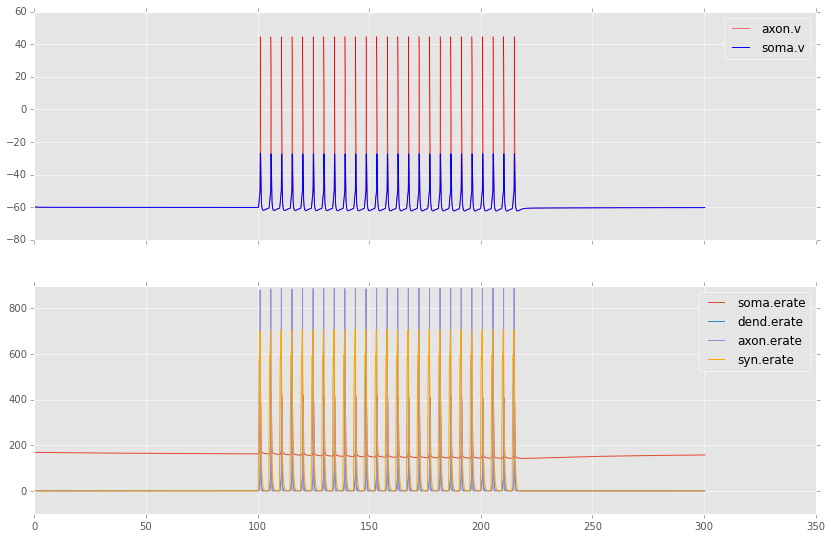

In [24]:
plot_traj(data)

(100, 105)

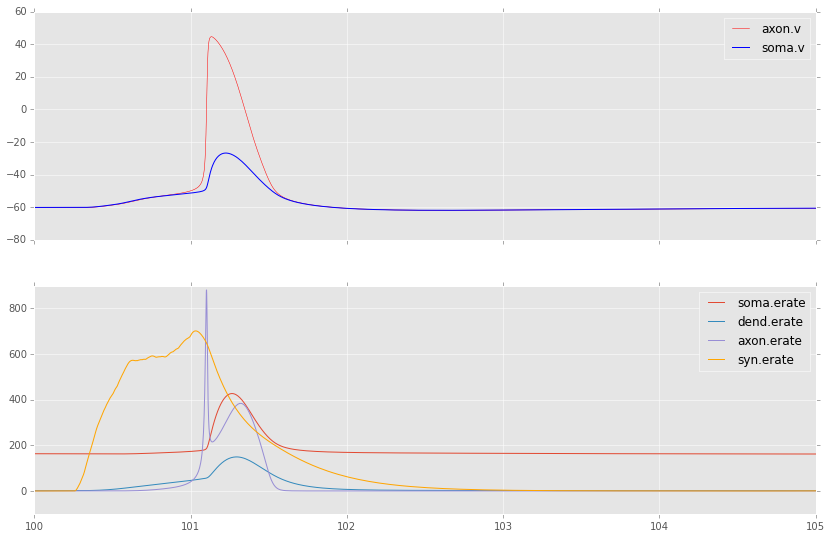

In [25]:
plot_traj(data)
xlim(100, 105)